### 주제 : 수치형 데이터셋에 Linear Regression Keras ver. 모델 적용해보기

![concrete](concrete.jpg)

### Kaggle Dataset - 콘크리트 강도 예측
    * features
        -Cement
        -Blast Furnace Slag (고로슬래그 : 용광로에서 나온 용철슬래그를 물이나 증기로 급냉하여 
                           유리질의 입상물을 만든 다음 건조시켜 미세한 분말로 분쇄하여 얻은 것)
        -Fly Ash (화력발전소에서 석탄을 원료로 하는 미분탄을 약 1,400℃-1,500℃의 
                 고온으로 소각시켰을 때 발생되는 먼지)
        -Water
        -Superplasticizer (고강도 콘크리트를 만드는 데 사용되는 첨가제)
        -Coarse Aggregate (콘크리트를 만들 때 사용되는 모래, 자갈, 쇄석, 슬래그, 재활용
                           콘크리트 및 토목 인조 골재 등등)
        -Fine Aggregate (Coarse Aggregate보다 고운 입자를 가지는 모래, 수르키(surki), 
                        석재(石砲), 탄 점토, 재, 비산회 등등)
        -Age
        
    * target
        -Strength

#### 라이브러리 임포트

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras import Sequential, backend
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib
from IPython.display import Image

matplotlib.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'
import warnings
warnings.filterwarnings(action='ignore') 
plt.style.use('ggplot')

#### 데이터 불러오기 및 탐색

In [2]:
concrete = pd.read_csv('concrete_data.csv')
cc = pd.DataFrame(concrete)
cc.head()
#1031 X 9

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [3]:
cc.isnull().sum()

Cement                0
Blast Furnace Slag    0
Fly Ash               0
Water                 0
Superplasticizer      0
Coarse Aggregate      0
Fine Aggregate        0
Age                   0
Strength              0
dtype: int64

In [4]:
cc.dtypes

Cement                float64
Blast Furnace Slag    float64
Fly Ash               float64
Water                 float64
Superplasticizer      float64
Coarse Aggregate      float64
Fine Aggregate        float64
Age                     int64
Strength              float64
dtype: object

In [5]:
cc.describe()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


#### 데이터의 이해를 높이기 위해 수분 농도 컬럼 추가

In [6]:
cc.insert(4, 'Water_Cement_ratio', cc['Water']/cc['Cement'])
cc.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Water_Cement_ratio,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
0,540.0,0.0,0.0,162.0,0.300000,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,0.300000,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.685714,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.685714,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.966767,0.0,978.4,825.5,360,44.30


####  Distplot으로 컬럼별 분포 확인

<AxesSubplot:xlabel='Strength', ylabel='Density'>

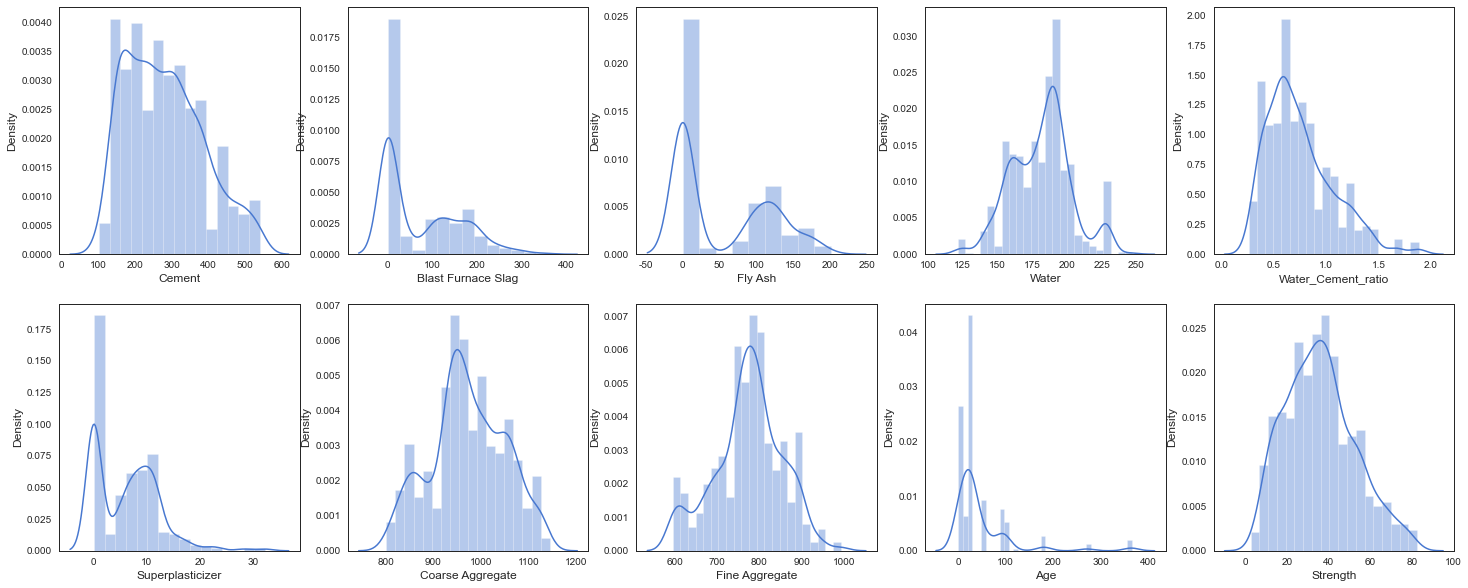

In [7]:
sns.set_palette("muted")
sns.set_style("white")
fig, ax2 = plt.subplots(2, 5, figsize = (25, 10))
sns.distplot(cc['Cement'],ax = ax2[0][0])
sns.distplot(cc['Blast Furnace Slag'],ax = ax2[0][1])
sns.distplot(cc['Fly Ash'],ax = ax2[0][2])
sns.distplot(cc['Water'],ax = ax2[0][3])
sns.distplot(cc['Water_Cement_ratio'],ax = ax2[0][4])
sns.distplot(cc['Superplasticizer'],ax = ax2[1][0])
sns.distplot(cc['Coarse Aggregate'],ax = ax2[1][1])
sns.distplot(cc['Fine Aggregate'],ax = ax2[1][2])
sns.distplot(cc['Age'],ax = ax2[1][3])
sns.distplot(cc['Strength'],ax = ax2[1][4])

#### Heatmap으로 컬럼간 상관관계 확인

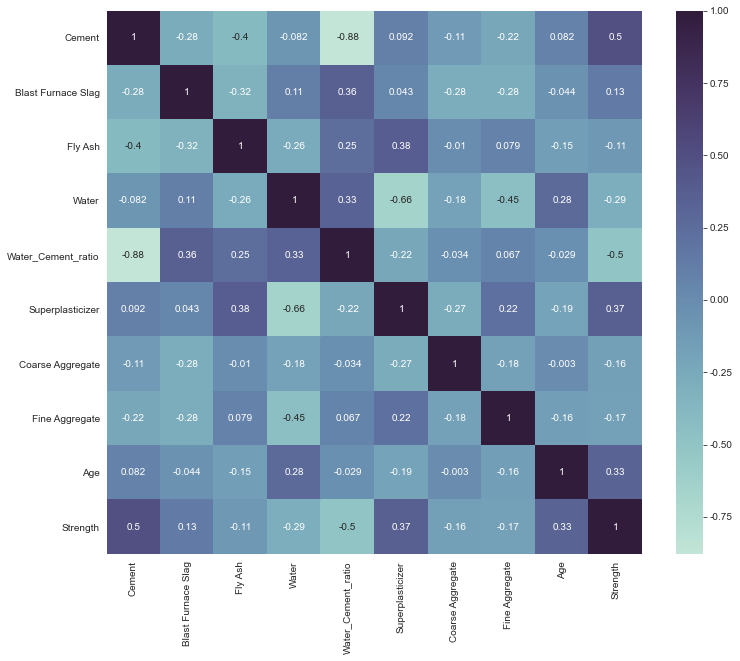

In [8]:
f, ax = plt.subplots(figsize = (12, 10))
cmap = sns.cubehelix_palette(start = .5, rot = -.5, as_cmap=True)
sns.heatmap(cc.corr(), annot = True, cmap = cmap)
plt.show()

#### 불필요하다 판단되는 Cement, Water 컬럼 삭제

In [9]:
cc = cc.drop(['Cement','Water'], axis=1)
cc.head()

,Blast Furnace Slag,Fly Ash,Water_Cement_ratio,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
0,0.0,0.0,0.300000,2.5,1040.0,676.0,28,79.99
1,0.0,0.0,0.300000,2.5,1055.0,676.0,28,61.89
2,142.5,0.0,0.685714,0.0,932.0,594.0,270,40.27
3,142.5,0.0,0.685714,0.0,932.0,594.0,365,41.05
4,132.4,0.0,0.966767,0.0,978.4,825.5,360,44.30


#### Outlier는 제거하지 않고 Standard Scailing

In [10]:
x_data = cc.iloc[:, :-1].values
y_data = cc.iloc[:, [-1]].values

In [11]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_data)

#### Train-Test Split

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_data, test_size=0.2)
#y_data 값이 1차원이기 때문에 stratify 사용 불가

In [13]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2)

In [14]:
x_train.shape, y_train.shape

((659, 7), (659, 1))

In [15]:
x_test.shape, y_test.shape

((206, 7), (206, 1))

####  backend를 사용하면 TensorFlow처럼 Keras에서도 variable을 만들거나 연산 가능
#### 검증수단은 rmse 사용

In [16]:
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

#### 모델링

In [17]:
model = Sequential()

model.add( Dense(512, activation = 'relu', input_dim = 7) )
model.add( BatchNormalization() )

model.add( Dense(units = 256, activation = 'relu') )
model.add( BatchNormalization() )

model.add( Dense(units = 128, activation = 'relu') )
model.add( BatchNormalization() )

model.add( Dense(units = 32, activation = 'relu') )
model.add( BatchNormalization() )

model.add( Dense(units = 1) )

model.compile( optimizer=Adam(0.001), loss='mean_squared_error', metrics=[rmse] )
h = model.fit( x_train, y_train, epochs=100, validation_data = (x_valid, y_valid), batch_size=32 )

Epoch 1/100
21/21 [==============================] - 1s 9ms/step - loss: 1443.1332 - rmse: 35.4882 - val_loss: 1467.8483 - val_rmse: 34.9937
Epoch 2/100
21/21 [==============================] - 0s 3ms/step - loss: 1380.7821 - rmse: 35.2970 - val_loss: 1444.1412 - val_rmse: 34.8645
Epoch 3/100
21/21 [==============================] - 0s 3ms/step - loss: 1340.0890 - rmse: 35.0691 - val_loss: 1376.8761 - val_rmse: 34.1259
Epoch 4/100
21/21 [==============================] - 0s 3ms/step - loss: 1305.4910 - rmse: 34.8003 - val_loss: 1323.9791 - val_rmse: 33.5961
Epoch 5/100
21/21 [==============================] - 0s 3ms/step - loss: 1272.0208 - rmse: 34.4880 - val_loss: 1249.9504 - val_rmse: 32.6611
Epoch 6/100
21/21 [==============================] - 0s 3ms/step - loss: 1237.2854 - rmse: 34.1356 - val_loss: 1146.3407 - val_rmse: 31.2526
Epoch 7/100
21/21 [==============================] - 0s 3ms/step - loss: 1199.7646 - rmse: 33.7444 - val_loss: 1066.3157 - val_rmse: 30.2793
Epoch 8/100
2

21/21 [==============================] - 0s 2ms/step - loss: 26.2548 - rmse: 3.8886 - val_loss: 30.5501 - val_rmse: 3.8341
Epoch 61/100
21/21 [==============================] - 0s 2ms/step - loss: 18.1401 - rmse: 3.1274 - val_loss: 34.4695 - val_rmse: 4.1206
Epoch 62/100
21/21 [==============================] - 0s 2ms/step - loss: 22.9583 - rmse: 3.6849 - val_loss: 28.1586 - val_rmse: 3.8241
Epoch 63/100
21/21 [==============================] - 0s 2ms/step - loss: 20.3139 - rmse: 3.4493 - val_loss: 27.9093 - val_rmse: 3.7358
Epoch 64/100
21/21 [==============================] - 0s 2ms/step - loss: 17.9628 - rmse: 3.2434 - val_loss: 23.4952 - val_rmse: 3.5614
Epoch 65/100
21/21 [==============================] - 0s 3ms/step - loss: 21.2225 - rmse: 3.5764 - val_loss: 26.3596 - val_rmse: 3.6097
Epoch 66/100
21/21 [==============================] - 0s 3ms/step - loss: 18.3774 - rmse: 3.2901 - val_loss: 27.5265 - val_rmse: 3.6120
Epoch 67/100
21/21 [==============================] - 0s 3ms/

In [18]:
h.history.keys()

dict_keys(['loss', 'rmse', 'val_loss', 'val_rmse'])

#### RMSE 변화 확인

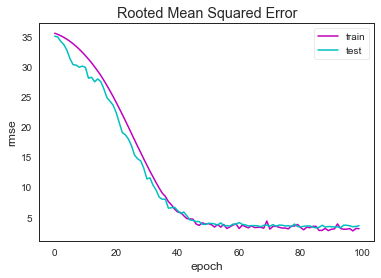

In [19]:
plt.plot(h.history['rmse'], color='m')
plt.plot(h.history['val_rmse'], color='c')
plt.title('Rooted Mean Squared Error')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

#### Loss 변화 확인

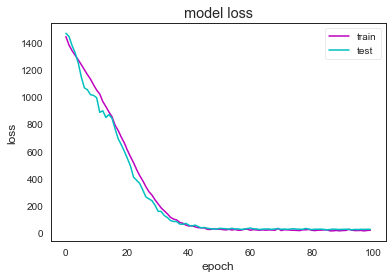

In [20]:
plt.plot(h.history['loss'], color='m')
plt.plot(h.history['val_loss'], color='c')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

#### R2 score 확인

In [21]:
predict_output = model.predict(x_valid)
result = r2_score(y_valid, predict_output)
print(f'R2-score in validation set : {np.round(result, 4)}')

R2-score in validation set : 0.9056


In [22]:
predict_output = model.predict(x_test)
result = r2_score(y_test, predict_output)
print(f'R2-score in test set : {np.round(result, 4)}')

R2-score in test set : 0.9034


#### Future task : rmse & loss 더 낮출 수 있는 모델링, image 모델 복습